In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text

database = 'grp20db_2023'
user = 'grp20_2023'
password = 'Q6JXVTt5'
host = 'dbcourse.cs.aalto.fi'

engine = create_engine(f'postgresql://{user}:{password}@{host}/{database}')
connection = engine.connect()

In [ ]:
# Plot 1: Vaccine Distribution Tracking
query1 = text("""
    SELECT manufdate, SUM(amount) as vaccines_distributed
    FROM vaccinebatch
    GROUP BY manufdate
    ORDER BY manufdate;
""")
df1 = pd.read_sql_query(query1, connection)

fig = plt.figure(figsize=(18, 8))
plt.plot(df1['manufdate'], df1['vaccines_distributed'])
plt.title('Vaccine Distribution Over Time')
plt.xlabel('Date')
plt.ylabel('Vaccines Distributed')
plt.show()

In [ ]:
# Plot 2: Vaccination Event Management
query2 = text("""
    SELECT location, COUNT(*) as vaccination_events
    FROM vaccinations
    GROUP BY location;
""")
df2 = pd.read_sql_query(query2, connection)

fig = plt.figure(figsize=(18, 8))
plt.bar(df2['location'], df2['vaccination_events'])
plt.title('Number of Vaccination Events by Location')
plt.xlabel('Location')
plt.ylabel('Number of Vaccination Events')
plt.show()

In [ ]:
# Plot 3: Patient Tracking
query3 = text("""
    SELECT date, COUNT(patientssno) as patients_vaccinated
    FROM vaccinepatients
    GROUP BY date
    ORDER BY date;
""")
df3 = pd.read_sql_query(query3, connection)

fig = plt.figure(figsize=(18, 8))
plt.plot(df3['date'], df3['patients_vaccinated'])
plt.title('Number of Patients Vaccinated Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Patients Vaccinated')
plt.show()

In [ ]:
# Plot 4: Vaccine Batch Tracking
query4 = text("""
    SELECT location, COUNT(batchid) as batches
    FROM vaccinebatch
    GROUP BY location;
""")
df4 = pd.read_sql_query(query4, connection)

fig = plt.figure(figsize=(18, 8))
plt.bar(df4['location'], df4['batches'])
plt.title('Distribution of Vaccine Batches Across Locations')
plt.ylabel('Number of Batches')
plt.xlabel('Location')
plt.show()

In [ ]:
# Plot 5: Symptom Analysis
query5 = text("""
    SELECT symptom, COUNT(patient) as frequency
    FROM diagnosis
    GROUP BY symptom;
""")
df5 = pd.read_sql_query(query5, connection)
df5 = df5.sort_values(by=['frequency'], ascending=False)
df5 = df5.head(10)

fig = plt.figure(figsize=(18, 8))
plt.bar(df5['symptom'], df5['frequency'])
plt.title('Frequency of Symptoms (top 10) in Vaccinated Patients')
plt.xlabel('Symptom')
plt.ylabel('Frequency')
plt.show()

C:\Users\Phuong\AppData\Local\Temp\ipykernel_22652\4055244596.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_other = df_other.groupby('gender').sum().reset_index()


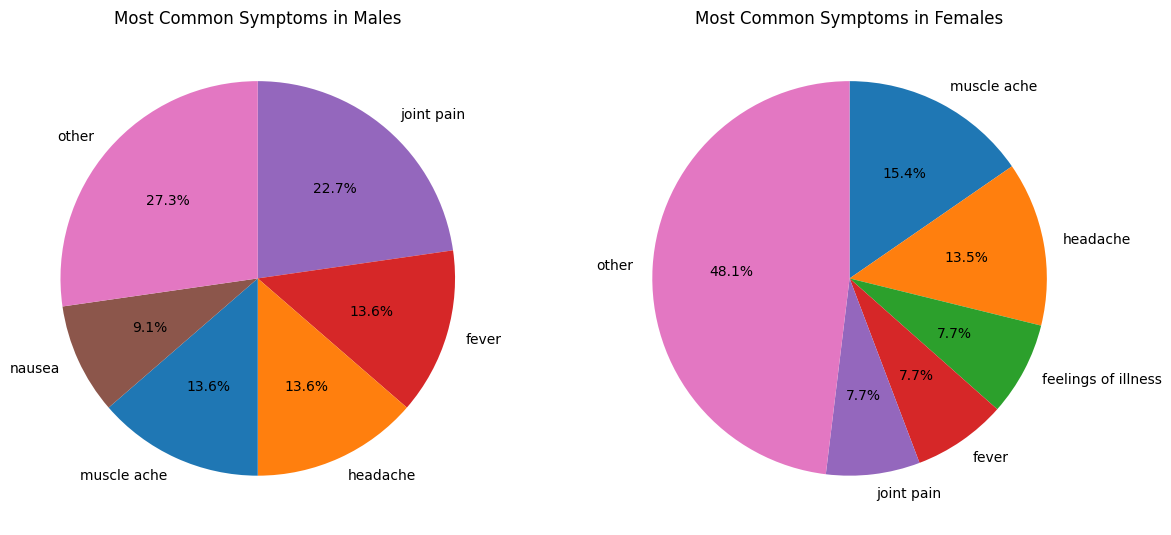

In [18]:
import matplotlib.colors as mcolors

# Get all distinct symptoms
all_symptoms = df_final['symptom'].unique()

# Generate a color for each symptom
colors = mcolors.TABLEAU_COLORS
symptom_colors = dict(zip(all_symptoms, colors))

df_patients_symptoms = pd.read_sql_query(text("SELECT * FROM diagnosis JOIN patients ON diagnosis.patient = patients.ssno"), connection)
df_patients_symptoms_male = df_patients_symptoms[df_patients_symptoms['gender'] == 'M']
df_patients_symptoms_female = df_patients_symptoms[df_patients_symptoms['gender'] == 'F']

df_male_symptoms = df_patients_symptoms_male.groupby('symptom')['patient'].nunique().reset_index()
df_female_symptoms = df_patients_symptoms_female.groupby('symptom')['patient'].nunique().reset_index()

df_male_symptoms['gender'] = 'M'
df_female_symptoms['gender'] = 'F'

df_all_symptoms = pd.concat([df_male_symptoms, df_female_symptoms])

# Getting the top 5 symptoms for each gender and the count of other symptoms
df_top_5 = df_all_symptoms.groupby('gender').apply(lambda x: x.nlargest(5, 'patient')).reset_index(drop=True)

df_other = df_all_symptoms[~df_all_symptoms.index.isin(df_top_5.index)]
df_other = df_other.groupby('gender').sum().reset_index()
df_other['symptom'] = 'other'

df_final = pd.concat([df_top_5, df_other])

# Plot pie charts
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# For male symptoms
axs[0].pie(df_final[df_final['gender'] == 'M']['patient'], labels = df_final[df_final['gender'] == 'M']['symptom'], 
           autopct='%1.1f%%', startangle=90, counterclock=False, colors=[symptom_colors[x] for x in df_final[df_final['gender'] == 'M']['symptom']])
axs[0].set_title('Most Common Symptoms in Males')

# For female symptoms
axs[1].pie(df_final[df_final['gender'] == 'F']['patient'], labels = df_final[df_final['gender'] == 'F']['symptom'], 
           autopct='%1.1f%%', startangle=90, counterclock=False, colors=[symptom_colors[x] for x in df_final[df_final['gender'] == 'F']['symptom']])
axs[1].set_title('Most Common Symptoms in Females')

plt.show()


In [21]:
df_patients = pd.read_sql_query(text("SELECT * FROM patients"), connection)
df_vaccinated_patients = pd.read_sql_query(text("SELECT * FROM vaccinepatients"), connection)

# Function to calculate age
def calculate_age(born):
    today = datetime.date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

# Function to calculate age group
def calculate_age_group(age):
    if age <= 10:
        return '0-10'
    elif age <= 20: 
        return '10-20'
    elif age <= 40:
        return '20-40'
    elif age <= 60:
        return '40-60'
    else:
        return '60+'

# Convert dob to datetime
df_patients['dob'] = pd.to_datetime(df_patients['dob'])

# Add a new column 'age' to df_patients
df_patients['age'] = df_patients['dob'].apply(calculate_age)

# Add a new column 'ageGroup' to df_patients
df_patients['ageGroup'] = df_patients['age'].apply(calculate_age_group)

# Function to calculate vaccination status
def calculate_vaccination_status(ssno):
    vaccination_count = df_vaccinated_patients[df_vaccinated_patients['patientssno'] == ssno].shape[0]
    if vaccination_count == 0:
        return 'No Dose'
    elif vaccination_count == 1:
        return '1 Dose'
    else:
        return '2 Doses'

# Add a new column 'vaccination status' to df_patients
df_patients['vaccination status'] = df_patients['ssno'].apply(calculate_vaccination_status)

df_age_status = df_patients.groupby(['ageGroup', 'vaccination status']).size().reset_index(name='count')
df_age_total = df_patients.groupby('ageGroup').size().reset_index(name='total')
df_percentage = df_age_status.merge(df_age_total, on='ageGroup', how='left')
df_percentage['percentage'] = df_percentage['count'] * 1.0 / df_percentage['total']

# Create color mapping for vaccination status
statuses = df_percentage['vaccination status'].unique()
colors = list(mcolors.TABLEAU_COLORS)
status_colors = dict(zip(statuses, colors))

# Create bar plot
plt.figure(figsize=(10,6))
sns.barplot(x='ageGroup', y='percentage', hue='vaccination status', data=df_percentage, palette=status_colors)
plt.title('Vaccination Percentage by Age Group')
plt.ylabel('Percentage')
plt.xlabel('Age Group')
plt.show()

NameError: name 'df_patients_age' is not defined